Eigenvalues (Preconditioned): [1.01272279 1.01340508 1.01416718 1.01612663 1.01973216 1.02862684]
Condition Number (Preconditioned): 1.0157042557531921


C:\Users\meier\AppData\Local\Temp\ipykernel_159236\2255745771.py:42: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  x, _ = spla.cg(A, b, tol=tol, maxiter=max_iter, callback=callback)
C:\Users\meier\AppData\Local\Temp\ipykernel_159236\2255745771.py:50: DeprecationWarning: scipy.sparse.linalg.gmres called without specifying `callback_type`. The default value will be changed in a future release. For compatibility, specify a value for `callback_type` explicitly, e.g., ``gmres(..., callback_type='pr_norm')``, or to retain the old behavior ``gmres(..., callback_type='legacy')``
  x, _ = spla.gmres(A, b, tol=tol, maxiter=max_iter, restart=restart, callback=callback)
C:\Users\meier\AppData\Local\Temp\ipykernel_159236\2255745771.py:50: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed 

Eigenvalues (Preconditioned): [1.01229474 1.01246583 1.01397785 1.01613982 1.01989311 1.02792201]
Condition Number (Preconditioned): 1.0154374651864146
Eigenvalues (Preconditioned): [1.01264847 1.0130062  1.01396806 1.01598705 1.01981865 1.02830309]
Condition Number (Preconditioned): 1.0154590842101041
Eigenvalues (Preconditioned): [1.01245114 1.01259666 1.01397071 1.01612578 1.0196169  1.02841692]
Condition Number (Preconditioned): 1.0157694272860625
Eigenvalues (Preconditioned): [1.01239152 1.01329451 1.0138476  1.0161639  1.01986654 1.02868194]
Condition Number (Preconditioned): 1.0160910320919863
Eigenvalues (Preconditioned): [1.01253764 1.01259085 1.01389601 1.01609702 1.01993718 1.02849029]
Condition Number (Preconditioned): 1.0157551209538949
Eigenvalues (Preconditioned): [1.01258281 1.01270949 1.01394977 1.01609649 1.01987123 1.02818177]
Condition Number (Preconditioned): 1.015405125418968
Eigenvalues (Preconditioned): [1.01243381 1.01247306 1.01410785 1.01629221 1.01990199 1.0

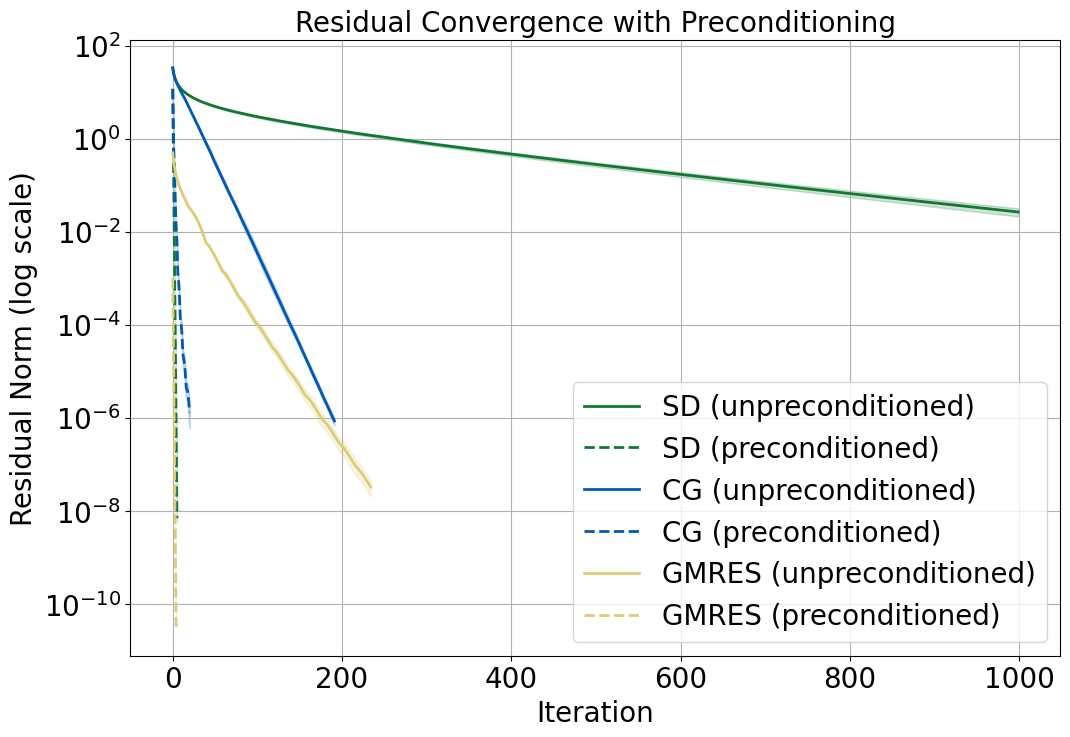

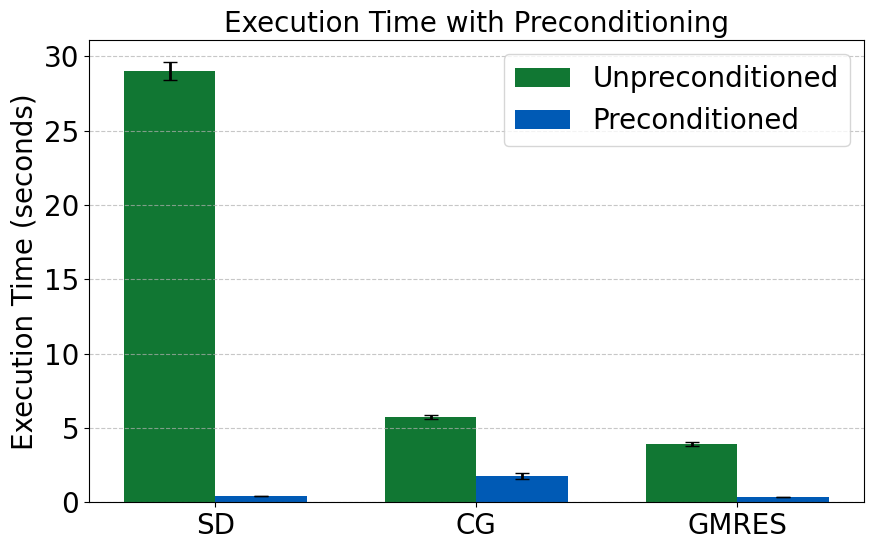

In [2]:
# %%
import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from time import time
from scipy.sparse.linalg import LinearOperator, cg, spilu, eigsh
from scipy.sparse import csc_matrix

def generate_gmres_favorable_matrix(size, condition_number, nonsymmetry_factor=0):
    """
    Generate a matrix that is challenging for Steepest Descent,
    intermediate for CG, and favorable for GMRES.
    """
    Q, _ = np.linalg.qr(np.random.randn(size, size))  # Random orthogonal matrix
    eigenvalues = np.linspace(1, condition_number, size)  # Controlled spectrum
    symmetric_part = Q @ np.diag(eigenvalues) @ Q.T  # SPD-like matrix

    # Add nonsymmetry to slightly favor GMRES
    skew_part = np.random.randn(size, size) * nonsymmetry_factor
    skew_part = skew_part - skew_part.T  # Skew-symmetric component

    return symmetric_part + skew_part

def steepest_descent(A, b, tol=1e-8, max_iter=1000):
    x = np.zeros_like(b)
    r = b - A @ x
    res = []
    for _ in range(max_iter):
        alpha = (r @ r) / (r @ (A @ r))
        x = x + alpha * r
        r = b - A @ x
        res.append(np.linalg.norm(r))
        if np.linalg.norm(r) < tol:
            break
    return x, res

def conjugate_gradient_scipy(A, b, tol=1e-8, max_iter=1000):
    """Conjugate Gradient Method using SciPy."""
    res = []
    def callback(xk):
        res.append(np.linalg.norm(b - A @ xk))  # Compute residual norm
    x, _ = spla.cg(A, b, tol=tol, maxiter=max_iter, callback=callback)
    return x, res

def gmres_scipy(A, b, tol=1e-8, max_iter=1000, restart=20):
    """GMRES using SciPy."""
    res = []
    def callback(rk):
        res.append(rk)
    x, _ = spla.gmres(A, b, tol=tol, maxiter=max_iter, restart=restart, callback=callback)
    return x, res

def generate_preconditioner(A):
    """
    Generate an Incomplete Cholesky preconditioner for SPD matrix A.
    """
    # Ensure matrix is in sparse CSC format for spilu
    A_csc = csc_matrix(A)
    # Compute Incomplete Cholesky factorization (drop_tol controls sparsity)
    ilu = spilu(A_csc, drop_tol=1e-3, fill_factor=10)
    # Return as LinearOperator for iterative solvers
    M = LinearOperator(A.shape, matvec=lambda x: ilu.solve(x), dtype=A.dtype)
    return M

def apply_preconditioner(M_inv, r):
    """
    Apply the preconditioner to a residual vector.
    """
    return M_inv @ r


def steepest_descent_precond(A, b, M_inv, tol=1e-8, max_iter=1000):
    """
    Steepest Descent method with preconditioning.
    """
    x = np.zeros_like(b)
    r = b - A @ x
    res = []
    for _ in range(max_iter):
        z = apply_preconditioner(M_inv, r)  # Preconditioned residual
        alpha = (r @ z) / (z @ (A @ z))
        x = x + alpha * z
        r = b - A @ x
        res.append(np.linalg.norm(r))
        if np.linalg.norm(r) < tol:
            break
    return x, res

def cg_preconditioned_scipy(A, b, M_inv, tol=1e-8, max_iter=1000):
    """
    Conjugate Gradient method with preconditioning using SciPy.
    """
    res = []
    def callback(xk):
        res.append(np.linalg.norm(b - A @ xk))  # Compute residual norm
    M = LinearOperator(matvec=lambda x: M_inv @ x, dtype=A.dtype, shape=A.shape)  # Preconditioner
    x, _ = spla.cg(A, b, tol=tol, maxiter=max_iter, callback=callback, M=M)
    return x, res

def gmres_restarted_precond(A, b, M_inv, tol=1e-8, max_iter=1000, restart=20):
    """
    GMRES method with preconditioning using SciPy.
    """
    res = []
    def callback(rk):
        res.append(rk)
    M = LinearOperator(matvec=lambda x: M_inv @ x, dtype=A.dtype, shape=A.shape)  # Preconditioner
    x, _ = spla.gmres(A, b, tol=tol, maxiter=max_iter, restart=restart, callback=callback, M=M)
    return x, res

# --- Benchmark Setup ---
np.random.seed(42)
matrix_size = 10_000
condition_number = 500
num_matrices = 10

# Storage for results
methods = ['SD', 'CG', 'GMRES']
all_residuals = {method: {'unpreconditioned': [], 'preconditioned': []} for method in methods}
all_times = {method: {'unpreconditioned': [], 'preconditioned': []} for method in methods}

for _ in range(num_matrices):
    A_favorable = generate_gmres_favorable_matrix(matrix_size, condition_number, 0)  
    b = np.random.rand(matrix_size)
    M_inv = generate_preconditioner(A_favorable)
    
    def preconditioned_matvec(x):
        return M_inv @ (A_favorable @ x)

    M_preconditioned = LinearOperator(A_favorable.shape, matvec=preconditioned_matvec)

    # Compute the largest and smallest eigenvalues of the preconditioned system
    eigvals_precond = eigsh(M_preconditioned, k=6, which='LM', return_eigenvectors=False)

    # Display the range of eigenvalues and condition number
    cond_precond = max(eigvals_precond) / min(eigvals_precond)
    print("Eigenvalues (Preconditioned):", eigvals_precond)
    print("Condition Number (Preconditioned):", cond_precond)

    # Unpreconditioned Methods
    start = time()
    _, res = steepest_descent(A_favorable, b)
    all_residuals['SD']['unpreconditioned'].append(res)
    all_times['SD']['unpreconditioned'].append(time() - start)

    start = time()
    _, res = conjugate_gradient_scipy(A_favorable, b)
    all_residuals['CG']['unpreconditioned'].append(res)
    all_times['CG']['unpreconditioned'].append(time() - start)

    start = time()
    _, res = gmres_scipy(A_favorable, b)
    all_residuals['GMRES']['unpreconditioned'].append(res)
    all_times['GMRES']['unpreconditioned'].append(time() - start)

    # Preconditioned Methods
    start = time()
    _, res = steepest_descent_precond(A_favorable, b, M_inv)
    all_residuals['SD']['preconditioned'].append(res)
    all_times['SD']['preconditioned'].append(time() - start)

    start = time()
    _, res = cg_preconditioned_scipy(A_favorable, b, M_inv)
    all_residuals['CG']['preconditioned'].append(res)
    all_times['CG']['preconditioned'].append(time() - start)

    start = time()
    _, res = gmres_restarted_precond(A_favorable, b, M_inv)
    all_residuals['GMRES']['preconditioned'].append(res)
    all_times['GMRES']['preconditioned'].append(time() - start)
    
print("First few unpreconditioned residuals:", all_residuals['CG']['unpreconditioned'][0][:5])
print("First few preconditioned residuals:", all_residuals['CG']['preconditioned'][0][:5])    

# --- Plot Residuals ---
plt.figure(figsize=(12, 8))
colors = {'SD': '#117733', 'CG': '#005AB5', 'GMRES': '#DDCC77'}
styles = {'unpreconditioned': '-', 'preconditioned': '--'}

for method in methods:
    for condition in ['unpreconditioned', 'preconditioned']:
        # Truncate residuals to the shortest convergence length
        min_len = min(len(res) for res in all_residuals[method][condition])
        truncated_residuals = np.array([res[:min_len] for res in all_residuals[method][condition]])
        mean_res = np.mean(truncated_residuals, axis=0)
        std_res = np.std(truncated_residuals, axis=0)

        plt.fill_between(range(len(mean_res)), mean_res - std_res, mean_res + std_res, color=colors[method], alpha=0.2)
        plt.semilogy(mean_res, label=f"{method} ({condition})", color=colors[method], linestyle=styles[condition], linewidth=2)

plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Residual Norm (log scale)', fontsize=20)
plt.title('Residual Convergence with Preconditioning', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

# --- Plot Execution Times ---
plt.figure(figsize=(10, 6))
x = np.arange(len(methods))
width = 0.35

# Define custom colors for each condition
colors = {
    'unpreconditioned': '#117733', 
    'preconditioned': '#005AB5' 
}

for i, condition in enumerate(['unpreconditioned', 'preconditioned']):
    times_mean = [np.mean(all_times[method][condition]) for method in methods]
    times_std = [np.std(all_times[method][condition]) for method in methods]

    plt.bar(x + (i - 0.5) * width, times_mean, width, yerr=times_std, label=condition.capitalize(), color=colors[condition], capsize=5, error_kw={'elinewidth': 2})

plt.xticks(x, methods)
plt.ylabel('Execution Time (seconds)', fontsize=20)
plt.title('Execution Time with Preconditioning', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\meier\AppData\Local\Temp\ipykernel_159236\3887901901.py:40: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  x, _ = spla.cg(A, b, tol=tol, maxiter=max_iter, callback=callback)
C:\Users\meier\AppData\Local\Temp\ipykernel_159236\3887901901.py:48: DeprecationWarning: scipy.sparse.linalg.gmres called without specifying `callback_type`. The default value will be changed in a future release. For compatibility, specify a value for `callback_type` explicitly, e.g., ``gmres(..., callback_type='pr_norm')``, or to retain the old behavior ``gmres(..., callback_type='legacy')``
  x, _ = spla.gmres(A, b, tol=tol, maxiter=max_iter, restart=restart, callback=callback)
C:\Users\meier\AppData\Local\Temp\ipykernel_159236\3887901901.py:48: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed 

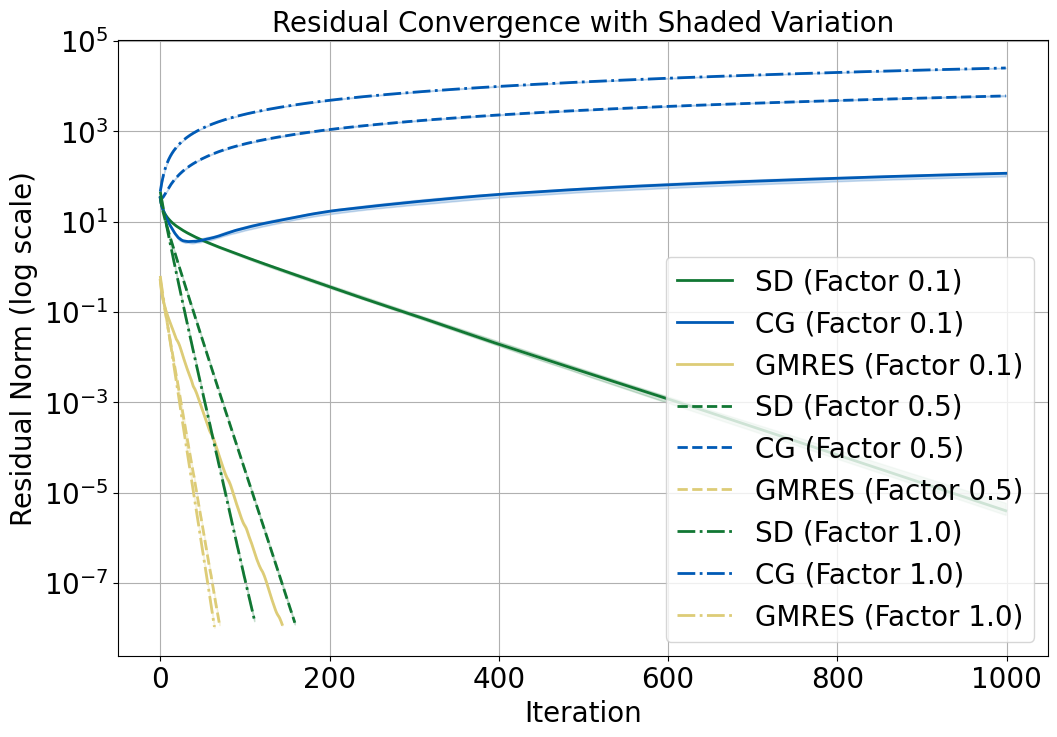

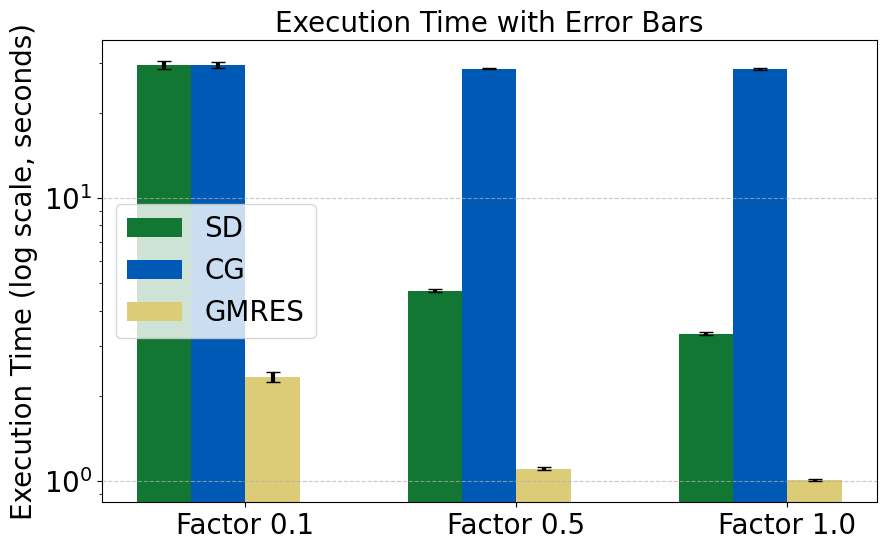

In [3]:
import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from time import time

def generate_gmres_favorable_matrix(size, condition_number, nonsymmetry_factor):
    """
    Generate a matrix that is challenging for Steepest Descent,
    intermediate for CG, and favorable for GMRES.
    """
    Q, _ = np.linalg.qr(np.random.randn(size, size))  # Random orthogonal matrix
    eigenvalues = np.linspace(1, condition_number, size)  # Controlled spectrum
    symmetric_part = Q @ np.diag(eigenvalues) @ Q.T  # SPD-like matrix

    # Add nonsymmetry to slightly favor GMRES
    skew_part = np.random.randn(size, size) * nonsymmetry_factor
    skew_part = skew_part - skew_part.T  # Skew-symmetric component

    return symmetric_part + skew_part

def steepest_descent(A, b, tol=1e-8, max_iter=1000):
    """Steepest Descent Method."""
    x = np.zeros_like(b)
    r = b - A @ x
    res = []
    for _ in range(max_iter):
        alpha = (r @ r) / (r @ (A @ r))
        x = x + alpha * r
        r = b - A @ x
        res.append(np.linalg.norm(r))
        if np.linalg.norm(r) < tol:
            break
    return x, res

def conjugate_gradient_scipy(A, b, tol=1e-8, max_iter=1000):
    """Conjugate Gradient Method using SciPy."""
    res = []
    def callback(xk):
        res.append(np.linalg.norm(b - A @ xk))  # Compute residual norm
    x, _ = spla.cg(A, b, tol=tol, maxiter=max_iter, callback=callback)
    return x, res

def gmres_restarted(A, b, tol=1e-8, max_iter=1000, restart=20):
    """Restarted GMRES using SciPy."""
    res = []
    def callback(rk):
        res.append(rk)
    x, _ = spla.gmres(A, b, tol=tol, maxiter=max_iter, restart=restart, callback=callback)
    return x, res

# Test setup
np.random.seed(42)
matrix_size = 10_000
condition_number = 500
asymmetry_factors = [0.1, 0.5, 1.0]
num_matrices = 10  # Number of random matrices to generate per asymmetry factor

# Storage for results
all_residuals = {factor: {method: [] for method in ['SD', 'CG', 'GMRES']} for factor in asymmetry_factors}
all_times = {factor: {method: [] for method in ['SD', 'CG', 'GMRES']} for factor in asymmetry_factors}

for factor in asymmetry_factors:
    for _ in range(num_matrices):
        A_favorable = generate_gmres_favorable_matrix(matrix_size, condition_number, factor)
        b = np.random.rand(matrix_size)

        # Steepest Descent
        start = time()
        _, res_sd = steepest_descent(A_favorable, b)
        time_sd = time() - start
        all_residuals[factor]['SD'].append(res_sd)
        all_times[factor]['SD'].append(time_sd)

        # Conjugate Gradient
        start = time()
        _, res_cg = conjugate_gradient_scipy(A_favorable, b)
        time_cg = time() - start

        all_residuals[factor]['CG'].append(res_cg)
        all_times[factor]['CG'].append(time_cg)

        # GMRES
        start = time()
        _, res_gmres = gmres_restarted(A_favorable, b)
        time_gmres = time() - start
        all_residuals[factor]['GMRES'].append(res_gmres)
        all_times[factor]['GMRES'].append(time_gmres)

# Plot residuals with shaded areas
colors = {'SD': '#117733', 'CG': '#005AB5', 'GMRES': '#DDCC77'}
linestyles = {0.1: '-', 0.5: '--', 1.0: '-.'}
plt.figure(figsize=(12, 8))

for factor in asymmetry_factors:
    for method in all_residuals[factor]:
        if not all_residuals[factor][method]:  # Skip if no residuals exist
            print(f"No residuals for {method} at factor {factor}")
            continue

        # Truncate residuals to the length of the shortest residual
        min_len = min(len(res) for res in all_residuals[factor][method])
        residuals = np.array([res[:min_len] for res in all_residuals[factor][method]])
        
        # Use median and interquartile range (IQR)
        median_res = np.median(residuals, axis=0)
        q1_res, q3_res = np.percentile(residuals, [25, 75], axis=0)

        plt.fill_between(range(len(median_res)), q1_res, q3_res, color=colors[method], alpha=0.2)
        plt.semilogy(median_res, label=f"{method} (Factor {factor})", color=colors[method], linestyle=linestyles[factor], linewidth=2)

plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Residual Norm (log scale)', fontsize=20)
plt.title('Residual Convergence with Shaded Variation', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

# Plot execution times with error bars
plt.figure(figsize=(10, 6))
width = 0.2
x = np.arange(len(asymmetry_factors))

for i, method in enumerate(colors.keys()):
    times_mean = [np.mean(all_times[factor][method]) if all_times[factor][method] else np.nan for factor in asymmetry_factors]
    times_std = [np.std(all_times[factor][method]) if all_times[factor][method] else 0 for factor in asymmetry_factors]

    plt.bar(x + (i - len(colors) / 2) * width, times_mean, width, yerr=times_std, label=method, color=colors[method], capsize=5, error_kw={'elinewidth': 3})

plt.xticks(x, [f"Factor {factor}" for factor in asymmetry_factors], fontsize=20)
plt.ylabel('Execution Time (log scale, seconds)', fontsize=20)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Execution Time with Error Bars', fontsize=20)
plt.legend(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
